In [1]:
import os
import math
import time
import pprint
import random
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm.notebook import tqdm
from IPython.display import display, Math
from matplotlib.patches import Rectangle

In [2]:
# custom imports
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..', 'utils')))

In [3]:
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta',
    'yellow', 'black', 'orange', 'purple', 'brown',
    'pink', 'grey', 'maroon', 'gold', 'chocolate',
    'aqua', 'darkviolet', 'crimson', 'navy', 'darkgreen',
    'peru', 'tan', 'seagreen', 'darkslategrey', 'teal'
]

In [4]:
# constants
A = 3e-4
use_sin = True

## First let's try to detect the helical trajectory (for the x-y plane) in a single-particle file

In [5]:
# Get all the "Hits" data files
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n1-1GeV-0.5eta')
hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
initial_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_initial.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])
dfs = [pd.read_csv(os.path.join(root_dir, file)) for file in hit_files]
initial_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
               for file in initial_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

In [6]:
random.seed(8)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
initial_df = initial_dfs[random_event]
final_df = final_dfs[random_event]
df['weight'] = 1.0
df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
df['phi'] = np.arctan2(df['ty'], df['tx'])
df['track'] = df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
df.head()

Event chosen: event000000029-hits.csv


,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index,weight,r,phi,track
0,4503599644147712,936748859932016764,16.683874,27.527729,7.455000,0.110797,0.510034,0.860154,0.231598,1.031892,0,0,0,0,0,1.0,32.188935,1.025922,"(32.18893472735766, 1.0259217315432712)"
1,4503599644147712,936748859932016778,17.186132,28.375340,7.683180,0.114188,0.509526,0.860455,0.231598,1.031892,0,0,0,0,1,1.0,33.174132,1.026217,"(33.174132070192734, 1.0262170908764479)"
2,4503599644147712,936748997370970502,34.540306,58.389202,15.712786,0.233525,0.491530,0.870861,0.231598,1.031892,0,0,0,0,2,1.0,67.840487,1.036611,"(67.84048693336703, 1.0366110277988427)"
3,4503599644147712,936749134809924310,57.039658,99.596489,26.586557,0.395131,0.466823,0.884351,0.231598,1.031892,0,0,0,0,3,1.0,114.773617,1.050687,"(114.7736170043114, 1.0506866179192182)"
4,4503599644147712,936749272248877138,81.947067,148.729919,39.344940,0.584747,0.437363,0.899285,0.231598,1.031892,0,0,0,0,4,1.0,169.811397,1.067202,"(169.81139727596994, 1.067201767998089)"


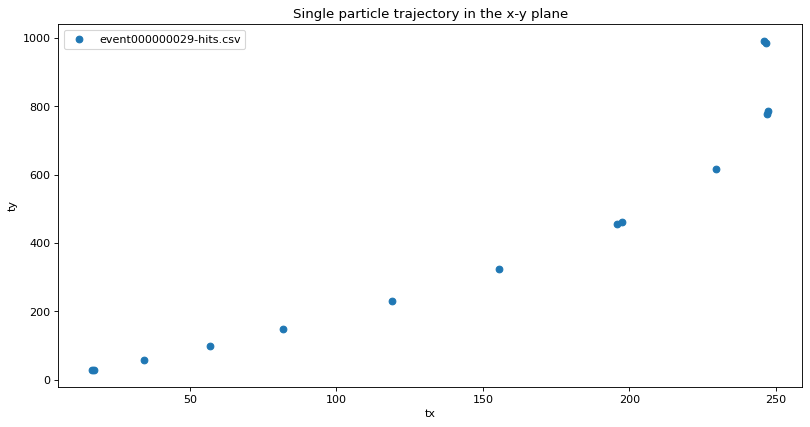

In [7]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=df['tx'], y=df['ty'], label=hit_files[random_event])

plt.xlabel('tx')
plt.ylabel('ty')
plt.legend(loc='best')
plt.title('Single particle trajectory in the x-y plane')
plt.show()

Let's define here the bin size and the range of search in the x-axis ($\phi_0$).

In [8]:
all_tracks = list(df['track'])
bin_size = (0.001, 0.05)
width_limits = (0, np.pi)
x_range = np.arange(width_limits[0], width_limits[1], bin_size[0])

Let's plot the tracks in the Hough Space.

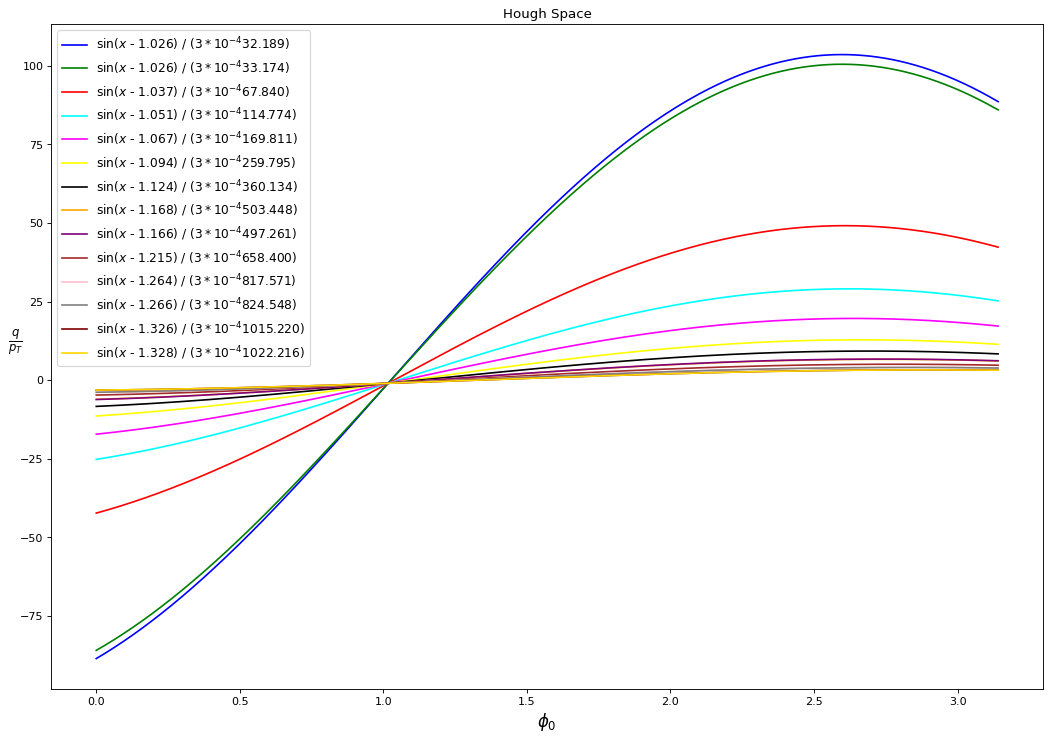

In [9]:
min_y, max_y = float('inf'), float('-inf')

plt.figure(figsize=(16, 11), dpi=80)
for idx, track in enumerate(all_tracks):
    r, phi = track
    if use_sin:
        label = '$\sin$($x$ - ' + '{:.3f}'.format(phi) + ') / ($3*10^{-4}$' + '{:.3f}'.format(r) + ')'
    else:
        label = '($x$ - ' + '{:.3f}'.format(phi) + ') / ($3*10^{-4}$' + '{:.3f}'.format(r) + ')'
    ys = np.sin(x_range - phi) / (A * r) if use_sin else (x_range - phi) / (A * r)
    min_y = min(np.min(ys), min_y)
    max_y = max(np.max(ys), max_y)
    plt.plot(x_range, ys, label=label, color=colors[idx % len(colors)])

plt.xlabel('$\phi_0$', fontsize=15)
h = plt.ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)
plt.title('Hough Space')
plt.legend(loc='best', prop={'size': 11})
plt.show()

Let's find the truth $\phi_0$ and $\frac{q}{p_T}$ values.

In [10]:
phi_truth = np.arctan2(initial_df['py'], initial_df['px']).item()
qpt_truth = (initial_df['q'] / np.sqrt(np.square(initial_df['px']) + np.square(initial_df['py']))).item()

display(Math('\\text{Truth} ' + '\;\; \phi_0 = {}'.format(phi_truth)))
display(Math('\\text{Truth} ' + '\;\; \\frac{q}{p_T} = ' + '{}'.format(qpt_truth)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's run the pipeline and plot the results.

In [11]:
from notebook_utils import pipeline

height_limits = (min_y - 1, max_y + 1)
limits = (width_limits, height_limits)
selection_hyperparams = {'minimum-hits-per-bin': 10}

accumulator, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, selection_hyperparams, use_sin=use_sin)
len(est_tracks_to_hits)

3

Before plotting, let's define a RoI (Region of Interest) in order to make the heatmap more readable.

In [12]:
lower_qpt = -1.11
upper_qpt = -0.85
low_qpt_bin = int((lower_qpt - height_limits[0] - 1e-12) / bin_size[1])
high_qpt_bin = int((upper_qpt - height_limits[0] - 1e-12) / bin_size[1])

lower_phi = 0.96
upper_phi = 1.06
low_phi_bin = int((lower_phi - width_limits[0] - 1e-12) / bin_size[0])
high_phi_bin = int((upper_phi - width_limits[0] - 1e-12) / bin_size[0])

roi_accumulator = accumulator[low_phi_bin:high_phi_bin, low_qpt_bin:high_qpt_bin]
roi_accumulator.shape

(100, 6)

In [13]:
truth_phi_bin = int((phi_truth - width_limits[0] - 1e-12) / bin_size[0])
truth_qpt_bin = int((qpt_truth - height_limits[0] - 1e-12) / bin_size[1])

roi_truth_phi_bin = int((phi_truth - lower_phi - 1e-12) / bin_size[0])
roi_truth_qpt_bin = int((qpt_truth - lower_qpt - 1e-12) / bin_size[1])
roi_truth_phi_bin, roi_truth_qpt_bin

(56, 2)

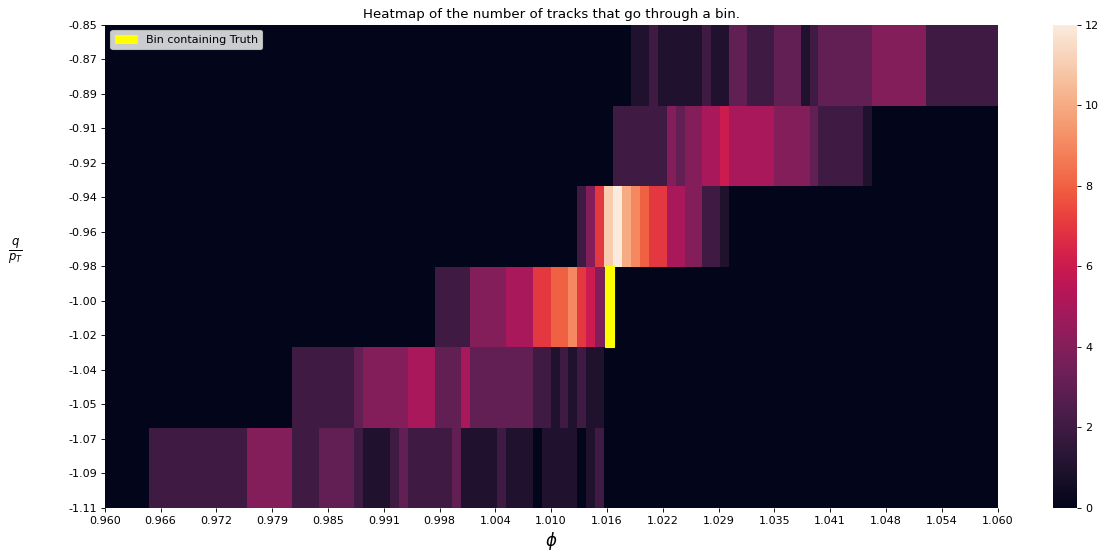

In [14]:
# size
plt.figure(figsize=(18, 8), dpi=80)

# x-axis ticks-labels
xbins = 17
plt.locator_params(axis='x', nbins=xbins)
xticks = np.linspace(0, roi_accumulator.shape[0], xbins)
x_range = np.linspace(lower_phi, upper_phi, xticks.shape[0])
xtick_labels = ['{:.3f}'.format(tick) for tick in x_range]

# y-axis ticks-labels
ybins = 15
plt.locator_params(axis='y', nbins=ybins)
yticks = np.linspace(0, roi_accumulator.shape[1], ybins)
y_range = np.linspace(lower_qpt, upper_qpt, yticks.shape[0])
ytick_labels = ['{:.2f}'.format(tick) for tick in y_range]

# heatmap
ax = sns.heatmap(roi_accumulator.T)

# config
ax.set_xlabel('$\phi$', fontsize=15)
h = ax.set_ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)

ax.yaxis.set_label_coords(-0.1, 0.50)
ax.invert_yaxis()

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=0)

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, rotation=0)

ax.set_title('Heatmap of the number of tracks that go through a bin.')
ax.add_patch(Rectangle((roi_truth_phi_bin, roi_truth_qpt_bin), 1, 1, color='yellow',
                       label='Bin containing Truth'))

ax.legend(loc='upper left')
plt.show()

## Let's now fix each axis to see how the counts in the bins of the other axis are distributed.

### Let's start with $\phi_0$

In [15]:
lower_qpt = -1.5
upper_qpt = -0.5
low_qpt_bin = int((lower_qpt - height_limits[0] - 1e-12) / bin_size[1])
high_qpt_bin = int((upper_qpt - height_limits[0] - 1e-12) / bin_size[1])

fixed_phi = truth_phi_bin

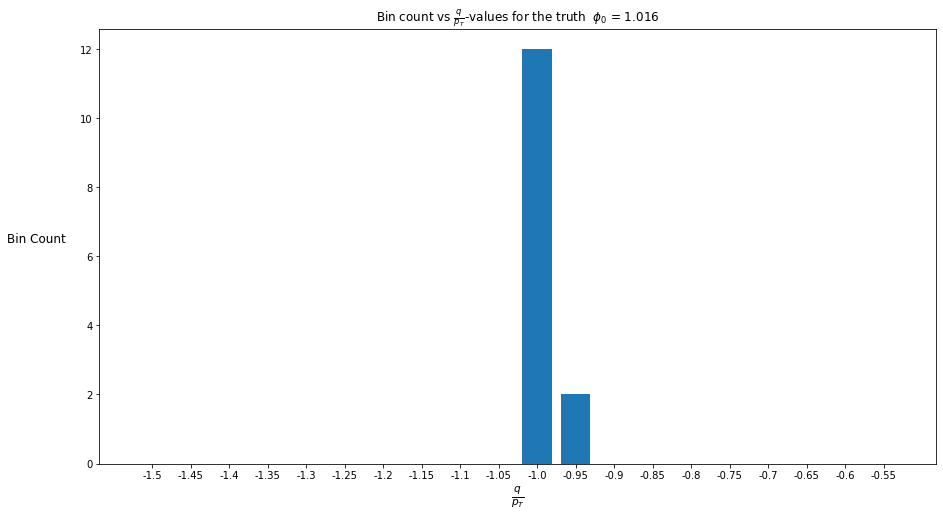

In [16]:
# accumulator region near optimal phi value
opt_phi_acc = accumulator[fixed_phi, low_qpt_bin:high_qpt_bin]

# plot the counts for q/p_T values near that region
fig, ax = plt.subplots(figsize=(15, 8))

# fix x-axis labels
xbins = opt_phi_acc.shape[0]
plt.locator_params(axis='x', nbins=xbins)
xticks = np.linspace(0, opt_phi_acc.shape[0], xbins)
x_range = np.arange(lower_qpt, upper_qpt, step=bin_size[1])
xtick_labels = ['{:.3}'.format(tick) for tick in x_range]

# plot the counts
ax.bar(xticks, opt_phi_acc)

# fix axes and labels
ax.set_xlabel('$\\frac{q}{p_T}$', fontsize=15)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=0)
h = ax.set_ylabel('Bin Count', fontsize=12)
h.set_rotation(0)
ax.yaxis.set_label_coords(-0.075, 0.50)
ax.set_title('Bin count vs $\\frac{q}{p_T}$-values for the truth  $\phi_0$ = ' + '{:.3f}'.format(phi_truth))

plt.show()

### Now let's do $\frac{q}{p_T}$

In [17]:
lower_phi = 0.96
upper_phi = 1.06
low_phi_bin = int((lower_phi - width_limits[0] - 1e-12) / bin_size[0])
high_phi_bin = int((upper_phi - width_limits[0] - 1e-12) / bin_size[0])

fixed_qpt = truth_qpt_bin

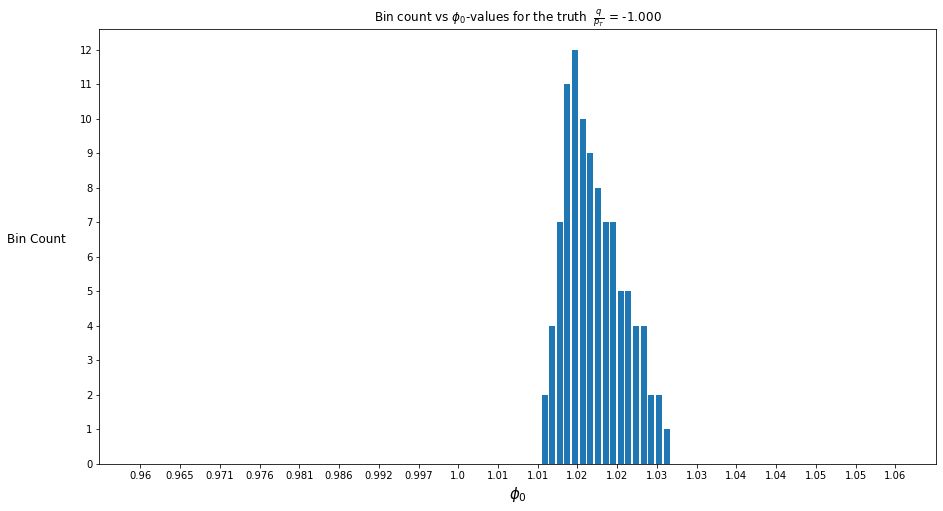

In [18]:
# accumulator region near optimal phi value
opt_phi_acc = accumulator[low_phi_bin:high_phi_bin, fixed_qpt]

# plot the counts for q/p_T values near that region
fig, ax = plt.subplots(figsize=(15, 8))

# fix x-axis labels
xbins = 20
plt.locator_params(axis='x', nbins=xbins)
xticks = np.linspace(0, opt_phi_acc.shape[0], xbins)
x_range = np.linspace(lower_phi, upper_phi, xbins)
xtick_labels = ['{:.3}'.format(tick) for tick in x_range]

# plot the counts
ax.bar(np.linspace(0, opt_phi_acc.shape[0], opt_phi_acc.shape[0]), opt_phi_acc)

# fix axes and labels
ax.set_xlabel('$\phi_0$', fontsize=15)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=0)
h = ax.set_ylabel('Bin Count', fontsize=12)
h.set_rotation(0)
ax.yaxis.set_label_coords(-0.075, 0.50)
yticks = np.arange(0, np.max(opt_phi_acc) + 1e-1, 1)
ax.set_yticks(yticks)
ax.set_title('Bin count vs $\phi_0$-values for the truth  $\\frac{q}{p_T}$ = ' + '{:.3f}'.format(qpt_truth))

plt.show()

## Let's compute and plot the residuals for many-particle datasets

In [19]:
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n25-0.5to10GeV-0.5eta')

hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])

dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
       for file in hit_files]
initial_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
               for file in initial_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

In [20]:
random.seed(2021)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
initial_df = initial_dfs[random_event]
final_df = final_dfs[random_event]
df['weight'] = 1.0
df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
df['phi'] = np.arctan2(df['ty'], df['tx'])
df['track'] = df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
initial_df['phi'] = np.arctan2(initial_df['py'], initial_df['px'])
initial_df['phi'] = initial_df['phi'].apply(lambda phi: phi + np.pi if phi < 0 else phi)
initial_df['pt'] = np.sqrt(np.square(initial_df['px']) + np.square(initial_df['py']))
initial_df['q/pt'] = initial_df['q'] / initial_df['pt']
df.head()

Event chosen: event000000051-hits.csv


,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index,weight,r,phi,track
0,4503599996469248,936748859932016652,31.950581,1.960413,10.167611,0.112050,5.853292,0.368759,1.862878,6.154550,0,0,0,0,0,1.0,32.010667,0.061281,"(32.0106673096836, 0.06128085312818037)"
1,4503600046800896,936748859932016652,31.212055,8.084858,8.601591,0.111488,1.746427,0.462362,0.481962,1.872762,0,0,0,0,0,1.0,32.242167,0.253459,"(32.24216676524436, 0.25345924255447094)"
2,4503600046800896,936748859932016666,32.001701,8.294030,8.819519,0.114312,1.746301,0.462835,0.481962,1.872762,0,0,0,0,1,1.0,33.059036,0.253595,"(33.05903551659354, 0.2535948267091365)"
3,4503599660924928,936748859932016679,-29.345648,-17.591038,-10.955899,0.119842,-7.877036,-4.733791,-2.942781,9.650265,0,0,0,0,1,1.0,34.214203,-2.601583,"(34.2142025434274, -2.601582947009528)"
4,4503599728033792,936748859932016679,-27.635937,-18.932758,1.574936,0.111876,-6.144863,-4.221881,0.350511,7.464425,0,0,0,0,1,1.0,33.499169,-2.540952,"(33.499169155855576, -2.540952158240271)"


In [21]:
all_tracks = list(df['track'])

bin_size = (0.01, 0.09)
width_limits = (0, np.pi)
height_limits = (-700, 700)
limits = (width_limits, height_limits)

x_range = np.arange(width_limits[0], width_limits[1], bin_size[0])
hyperparams = {'minimum-hits-per-bin': 10}

In [22]:
from metrics import get_track_to_truth_row_mapping, matching_probability

def custom_efficiency_rate(est_tracks_to_hits, truth_df, threshold=0.5):
    """ Custom efficiency rate function. The difference is that it also returns the reconstructed particles. """
    num_true_particles = len(set(truth_df['particle_id']))
    track_to_truth_df_row = get_track_to_truth_row_mapping(truth_df)
    found_particles = set()
    pid_to_est_track = {}
    
    for track, hits in est_tracks_to_hits.items():
        pid, prob = matching_probability(hits, track_to_truth_df_row, truth_df)
        if prob >= threshold and pid not in found_particles:
            found_particles.add(pid)
            pid_to_est_track[pid] = track
        if len(found_particles) == num_true_particles:
            break

    return pid_to_est_track, len(found_particles) / len(set(truth_df['particle_id']))

In [23]:
_, precise_est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, hyperparams, use_sin=True)
precise_pid_to_est_track, precise_efficiency = custom_efficiency_rate(precise_est_tracks_to_hits, df)

_, approx_est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, hyperparams, use_sin=False)
approx_pid_to_est_track, approx_efficiency = custom_efficiency_rate(approx_est_tracks_to_hits, df)

### Let's compute the residuals.

In [24]:
precise_phi_residuals = {}
precise_qpt_residuals = {}
for pid, track in precise_pid_to_est_track.items():
    phi, qpt = track

    particle_df = initial_df[initial_df['particle_id'] == pid]
    true_phi = particle_df['phi'].iloc[0]
    true_qpt = particle_df['q/pt'].iloc[0]

    precise_phi_residuals[pid] = np.abs(phi - true_phi)
    precise_qpt_residuals[pid] = np.abs(qpt - true_qpt)
    
approx_phi_residuals = {}
approx_qpt_residuals = {}
for pid, track in approx_pid_to_est_track.items():
    phi, qpt = track

    particle_df = initial_df[initial_df['particle_id'] == pid]
    true_phi = particle_df['phi'].iloc[0]
    true_qpt = particle_df['q/pt'].iloc[0]

    approx_phi_residuals[pid] = np.abs(phi - true_phi)
    approx_qpt_residuals[pid] = np.abs(qpt - true_qpt)    

Let's now plot the differences.

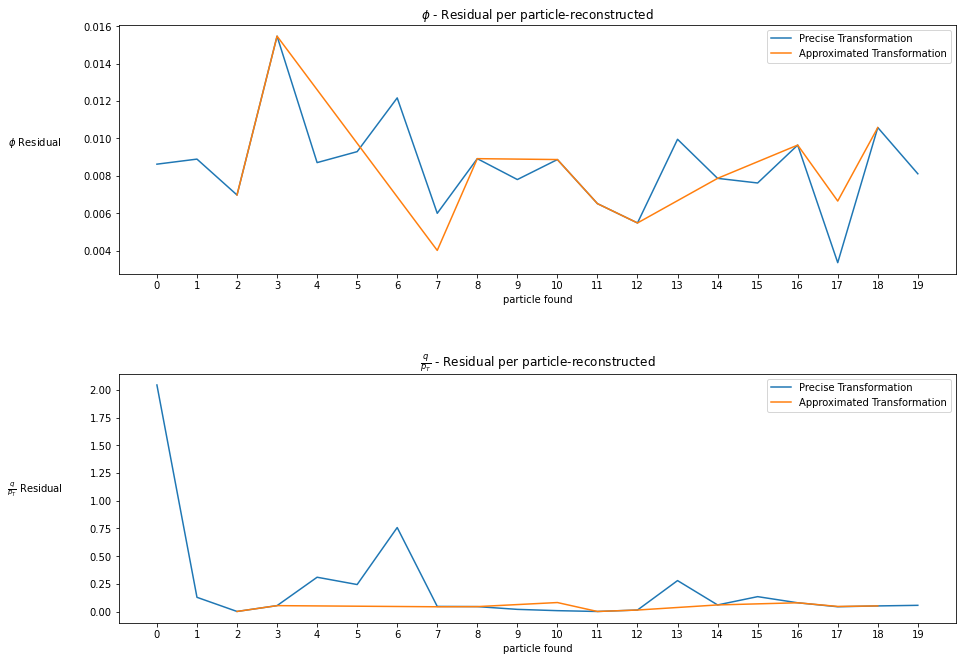

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 11))
fig.subplots_adjust(hspace=0.4)

# first plot: residual per phi
k1 = sorted(list(precise_phi_residuals.keys()))
d1 = {pid: precise_phi_residuals[pid] for pid in k1}

k2 = sorted(list(approx_phi_residuals.keys()))
d2 = {pid: approx_phi_residuals[pid] for pid in k2}

s = set(k1) | set(k2)

# plot the residuals
ax1.plot(list(d1.keys()), list(d1.values()), label='Precise Transformation')
ax1.plot(list(d2.keys()), list(d2.values()), label='Approximated Transformation')

ax1.set_xlabel('particle found')
xticks = np.arange(0, len(s))
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=0)
h = ax1.set_ylabel('$\phi$ Residual')
h.set_rotation(0)
ax1.yaxis.set_label_coords(-0.1, 0.50)
ax1.set_title('$\phi$ - Residual per particle-reconstructed')
ax1.legend()


# second plot: residual per q/p_T
k1 = sorted(list(precise_qpt_residuals.keys()))
d1 = {pid: precise_qpt_residuals[pid] for pid in k1}

k2 = sorted(list(approx_qpt_residuals.keys()))
d2 = {pid: approx_qpt_residuals[pid] for pid in k2}

s = set(k1) | set(k2)

# plot the residuals
ax2.plot(list(d1.keys()), list(d1.values()), label='Precise Transformation')
ax2.plot(list(d2.keys()), list(d2.values()), label='Approximated Transformation')

ax2.set_xlabel('particle found')
xticks = np.arange(0, len(s))
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, rotation=0)
h = ax2.set_ylabel('$\\frac{q}{p_T}$ Residual')
h.set_rotation(0)
ax2.yaxis.set_label_coords(-0.1, 0.50)
ax2.set_title('$\\frac{q}{p_T}$ - Residual per particle-reconstructed')
ax2.legend()

plt.show()